In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [65]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. Windows에 기본 설치된 한글 폰트 설정 (예: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

##### 업데이트된 하이퍼파라미터 자료조사 링크 (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

## 데이터 불러오기 및 순서형, 명목형 정의

In [68]:
# 데이터 불러오기
df = pd.read_csv("졸음분석 설문지 응답 시트.csv")

# 불필요한 열 제거
df = df.dropna(axis=1, how='all')  # Unnamed 열 제거
df = df.dropna(subset=["졸음 여부"])  # 타겟 결측 제거

# 문자열 통일
df['3. 교수님의 수업 스타일은 어떠신가요?'] = df['3. 교수님의 수업 스타일은 어떠신가요?'].replace({
    '강의자료 외 다양한 참고 자료(영상, 논문, 책 등)를 활용하는 수업': '강의 자료 외 다양한 참고 자료(영상, 논문, 책 등)를 활용하는 수업',
    'PPT 강의자료를 이용한 수업':'PPT 강의 자료를 이용한 수업'
})
df['14. 수업 전 카페인 섭취하셨나요?'] = df['14. 수업 전 카페인 섭취하셨나요?'].replace({
    '수업 시간 30분 전 ~ 수업시작 직전에 섭취': '수업 시간 30분 전 ~ 수업 시작 직전에 섭취'
})

# 변수 리스트 정의
ordinal_cols = [
    '7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간)',
    '9. 강의실 체감 온도는 어땠나요?',
    '10. 강의실 체감 혼잡도는 어땠나요? (좌석 점유 비율)',
    '11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요?',
    '12. 수업 전날 몇시간 주무셨나요?',
    '16.  수업이 몇시에 시작했나요?',
    '17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이)',
    '18. 수업의 체감 난이도는 어땠나요?',
    '19. 해당 수업에 얼마나 흥미를 느끼셨나요?'
]

nominal_cols = [
    '2. 수업의 구분을 선택해주세요.',
    '3. 교수님의 수업 스타일은 어떠신가요?',
    '4. 교수님이 수업 중에 어떤 식으로 질문하셨나요?',
    '5. 질문에 답을 하면 추가 점수를 주셨나요?',
    '6. 교수님의 수업 톤의 높낮이가 어떤가요?',
    '8.  강의실 조도는 어땠나요?',
    '13. 수업 전 1시간 이내에 식사를 하셨나요?',
    '14. 수업 전 카페인 섭취하셨나요?',
    '15.  수업이 무슨 요일에 있었나요?',
    '20. 직전에 수업이 있었나요? (연강)'
]
target_col = '졸음 여부'

## EDA

In [70]:
df.info()              # 변수별 타입, 결측치
df.describe()          # 수치형 요약 통계
df.isnull().sum()      # 결측치 개수 확인
df['졸음 여부'].value_counts(normalize=True)  # 클래스 비율

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   현재 학년을 선택해주세요.                              143 non-null    object 
 1   본인 학점을 기입해주세요.                              143 non-null    float64
 2   1. 수업명을 기입해주세요.                             143 non-null    object 
 3   2. 수업의 구분을 선택해주세요.                          143 non-null    object 
 4   3. 교수님의 수업 스타일은 어떠신가요?                      143 non-null    object 
 5   4. 교수님이 수업 중에 어떤 식으로 질문하셨나요?                143 non-null    object 
 6   5. 질문에 답을 하면 추가 점수를 주셨나요?                   143 non-null    object 
 7   6. 교수님의 수업 톤의 높낮이가 어떤가요?                    143 non-null    object 
 8   7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간)             143 non-null    object 
 9   8.  강의실 조도는 어땠나요?                           143 non-null    object 
 10  9. 강의실 체감 온도는 

졸음 여부
1    0.503497
0    0.496503
Name: proportion, dtype: float64

★ 7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간) 응답 분포:
7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간)
~ 10분 미만           44
10분 이상 ~ 30분 미만    42
1시간 이상 ~ 2시간 미만    31
30분 이상 ~ 1시간 미만    25
2시간 이상 ~            1
Name: count, dtype: int64


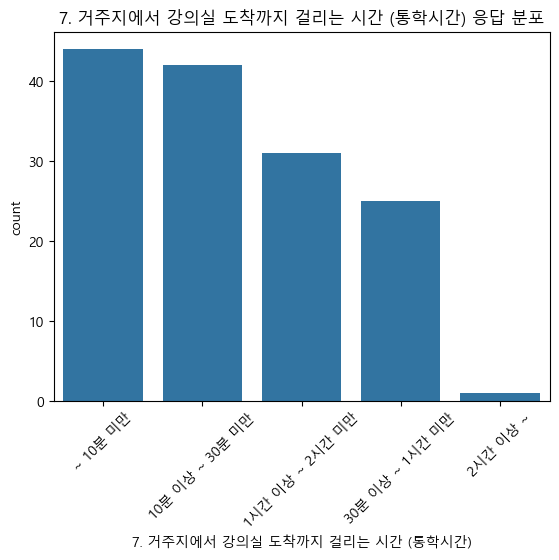

★ 9. 강의실 체감 온도는 어땠나요? 응답 분포:
9. 강의실 체감 온도는 어땠나요?
적당했음      108
더웠음        22
추웠음        10
매우 더웠음      3
Name: count, dtype: int64


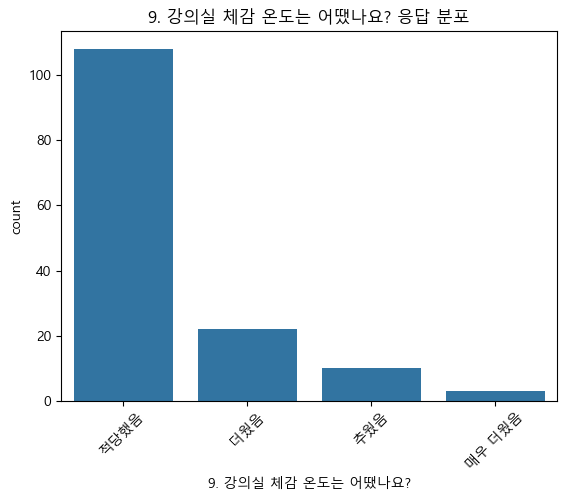

★ 10. 강의실 체감 혼잡도는 어땠나요? (좌석 점유 비율) 응답 분포:
10. 강의실 체감 혼잡도는 어땠나요? (좌석 점유 비율)
강의실의 100% 이하 ~ 60% 초과    93
강의실의 60% 이하 ~ 30%초과      45
강의실의 30% 이하               5
Name: count, dtype: int64


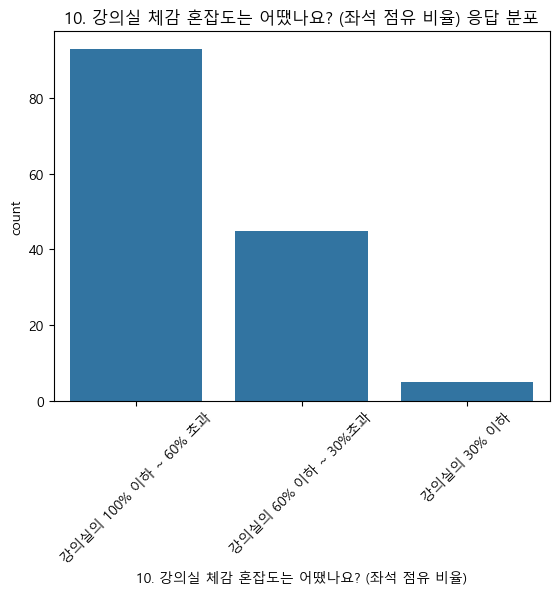

★ 11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요? 응답 분포:
11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요?
중간쪽    57
앞쪽     48
뒷쪽     38
Name: count, dtype: int64


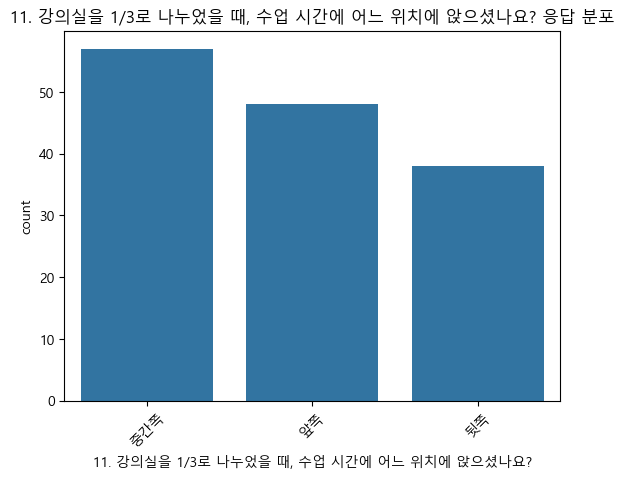

★ 12. 수업 전날 몇시간 주무셨나요? 응답 분포:
12. 수업 전날 몇시간 주무셨나요?
6시간 이상 ~ 8시간 미만    75
4시간 이상 ~ 6시간 미만    55
8시간 이상             10
2시간 미만              3
Name: count, dtype: int64


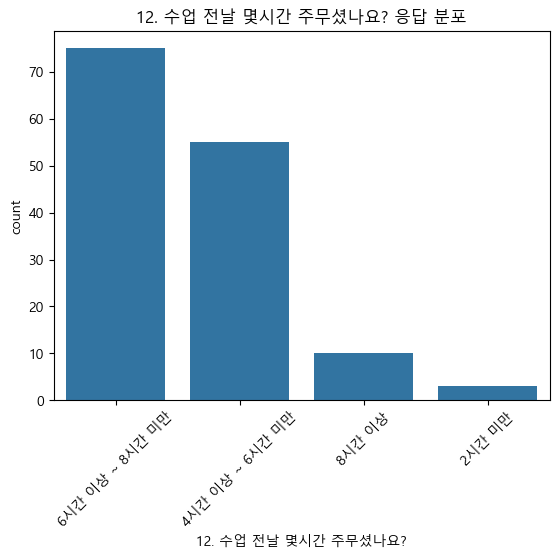

★ 16.  수업이 몇시에 시작했나요? 응답 분포:
16.  수업이 몇시에 시작했나요?
오전 8시 ~ 오전 10시     48
오후 1시 ~ 오후 2시      40
오후 3시 ~ 오후 4시      30
오전 11시 ~ 오후 12시    23
오후 6시 이후            1
오후 5시 ~ 오후 6시       1
Name: count, dtype: int64


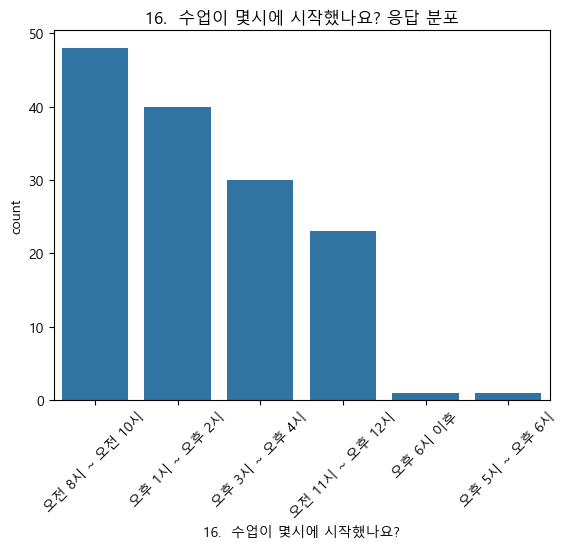

★ 17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이) 응답 분포:
17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이)
40분 이상 ~ 1시간 미만        60
1시간 이상 ~ 1시간 30분 미만    57
1시간 30분 이상 ~ 2시간 미만    19
2시간 이상                  6
40분 이내                  1
Name: count, dtype: int64


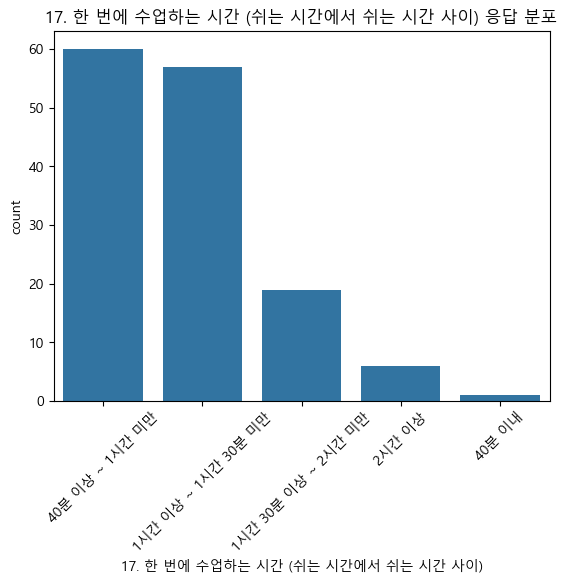

★ 18. 수업의 체감 난이도는 어땠나요? 응답 분포:
18. 수업의 체감 난이도는 어땠나요?
4    62
3    51
2    16
5    14
Name: count, dtype: int64


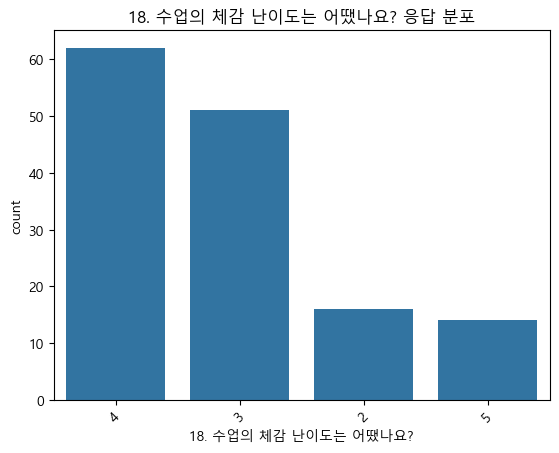

★ 19. 해당 수업에 얼마나 흥미를 느끼셨나요? 응답 분포:
19. 해당 수업에 얼마나 흥미를 느끼셨나요?
4    45
1    36
2    27
3    21
5    14
Name: count, dtype: int64


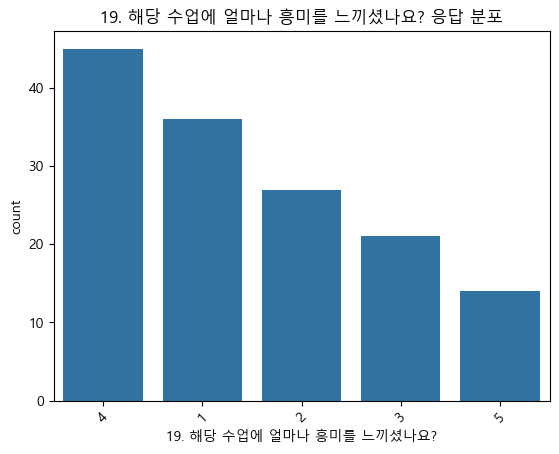

In [71]:
# 순서형 응답분포
for col in ordinal_cols:
    print(f"★ {col} 응답 분포:")
    print(df[col].value_counts())
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} 응답 분포")
    plt.xticks(rotation=45)
    plt.show()

☆ 2. 수업의 구분을 선택해주세요. 분포:
2. 수업의 구분을 선택해주세요.
전공 필수    62
전공 선택    37
교양 필수    29
교양 선택    15
Name: count, dtype: int64


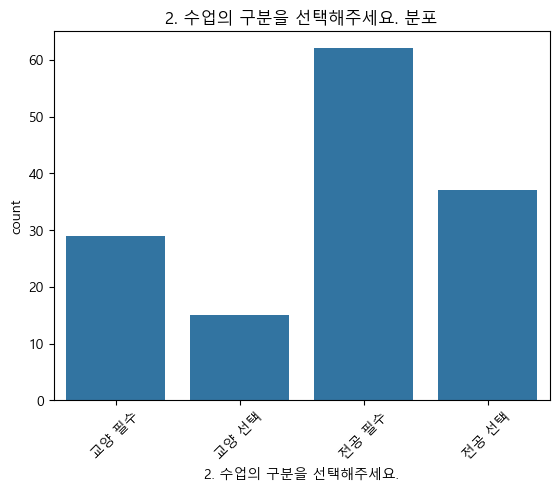

☆ 3. 교수님의 수업 스타일은 어떠신가요? 분포:
3. 교수님의 수업 스타일은 어떠신가요?
PPT 강의 자료를 이용한 수업                          82
판서 중심 수업                                   30
학생 참여형 토론 수업                               20
강의 자료 외 다양한 참고 자료(영상, 논문, 책 등)를 활용하는 수업    11
Name: count, dtype: int64


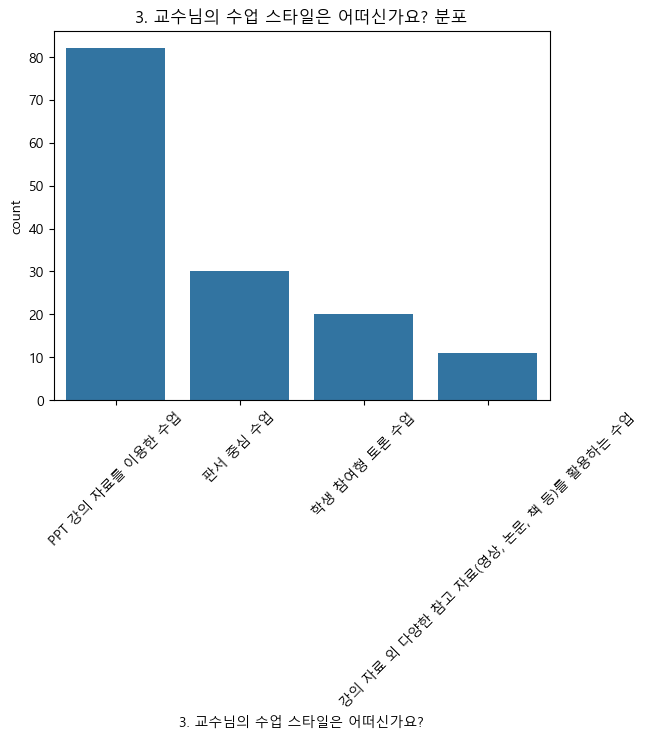

☆ 4. 교수님이 수업 중에 어떤 식으로 질문하셨나요? 분포:
4. 교수님이 수업 중에 어떤 식으로 질문하셨나요?
특정 학생을 호명하지 않고 질문    55
질문하지 않음              49
특정 학생을 호명하여 질문       39
Name: count, dtype: int64


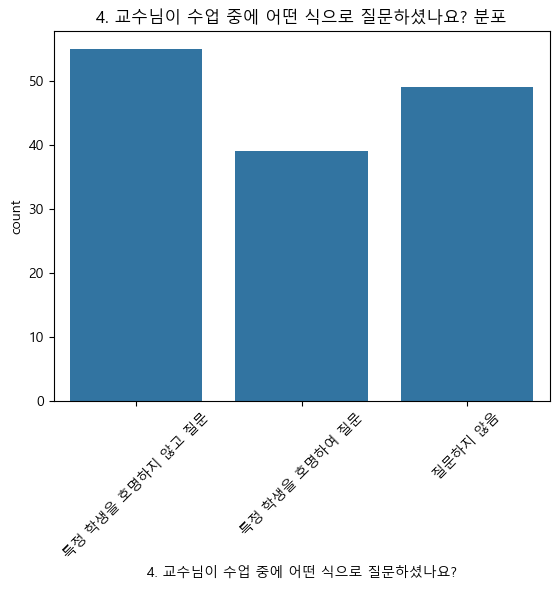

☆ 5. 질문에 답을 하면 추가 점수를 주셨나요? 분포:
5. 질문에 답을 하면 추가 점수를 주셨나요?
아니오    120
예       23
Name: count, dtype: int64


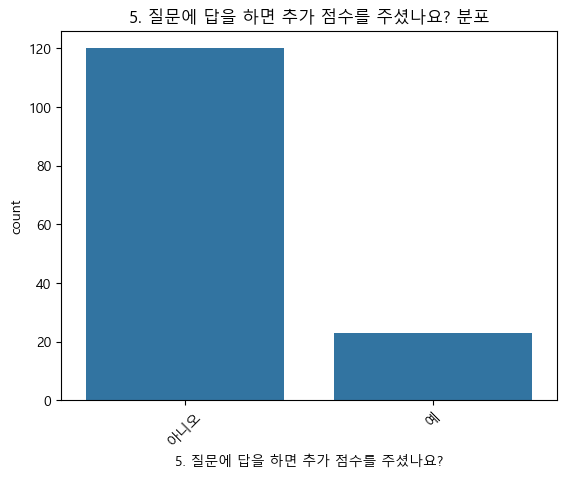

☆ 6. 교수님의 수업 톤의 높낮이가 어떤가요? 분포:
6. 교수님의 수업 톤의 높낮이가 어떤가요?
톤의 높낮이가 단조롭다    81
톤의 높낮이가 다양하다    62
Name: count, dtype: int64


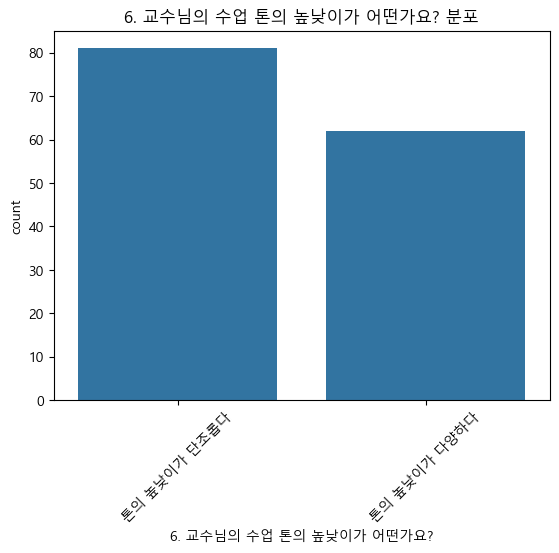

☆ 8.  강의실 조도는 어땠나요? 분포:
8.  강의실 조도는 어땠나요?
전체 조명 ON        117
뒷쪽 좌석 전등만 ON     13
칠판쪽 전등만 ON        7
전체 조명 OFF         6
Name: count, dtype: int64


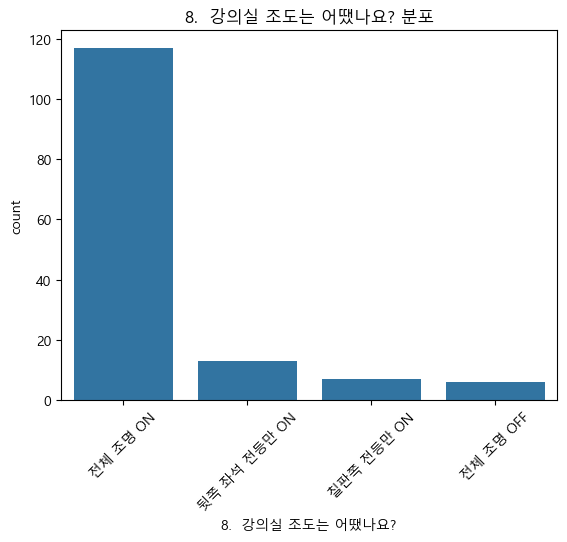

☆ 13. 수업 전 1시간 이내에 식사를 하셨나요? 분포:
13. 수업 전 1시간 이내에 식사를 하셨나요?
아니오    79
예      64
Name: count, dtype: int64


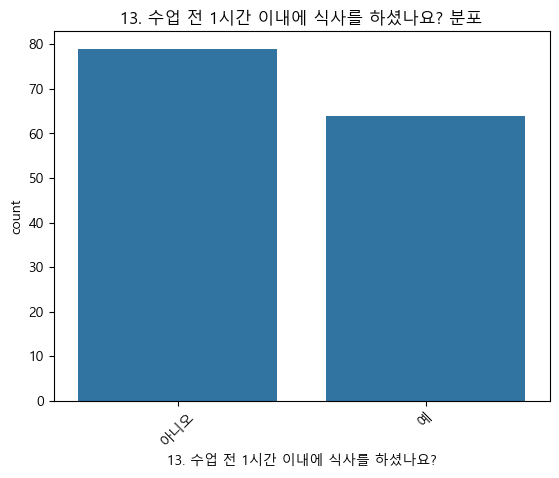

☆ 14. 수업 전 카페인 섭취하셨나요? 분포:
14. 수업 전 카페인 섭취하셨나요?
카페인 섭취하지 않음                   94
수업 중에 섭취                      19
수업 시간 30분 전 ~ 수업 시작 직전에 섭취    16
수업 1시간 전 ~ 31분 전에 섭취          14
Name: count, dtype: int64


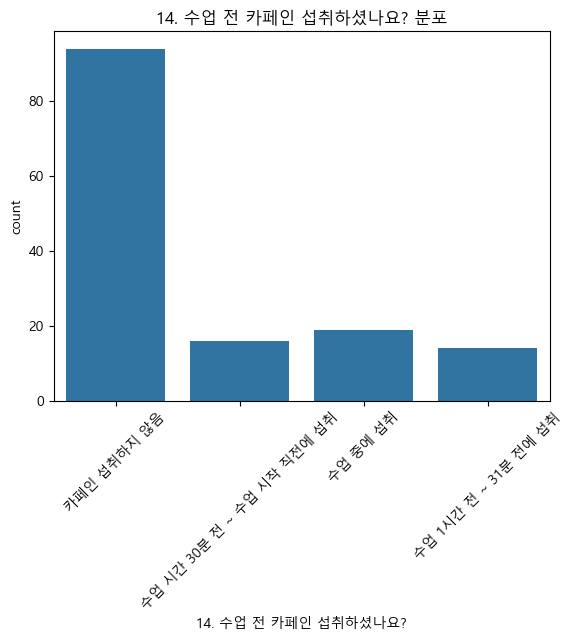

☆ 15.  수업이 무슨 요일에 있었나요? 분포:
15.  수업이 무슨 요일에 있었나요?
화    44
수    35
월    30
목    21
금    13
Name: count, dtype: int64


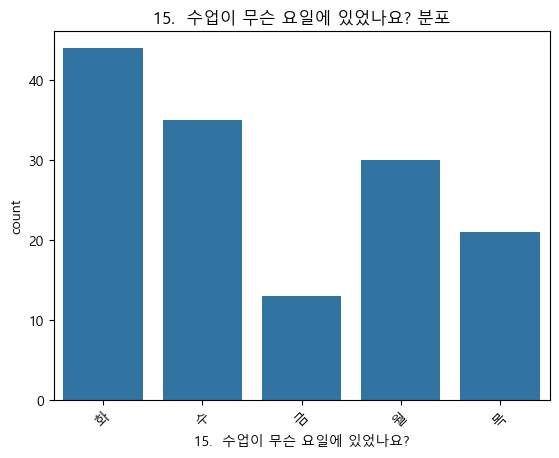

☆ 20. 직전에 수업이 있었나요? (연강) 분포:
20. 직전에 수업이 있었나요? (연강)
아니오    103
예       40
Name: count, dtype: int64


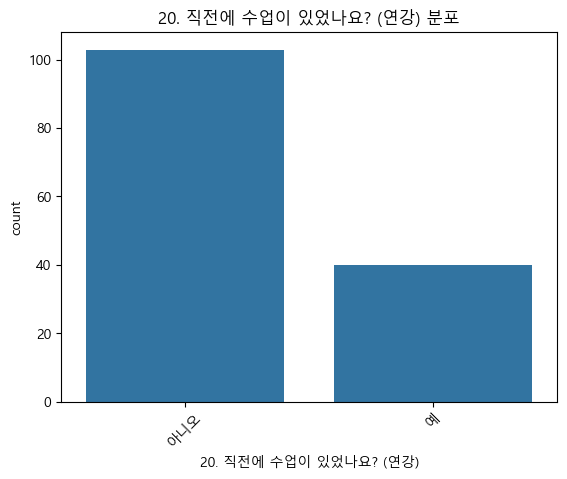

In [72]:
# 명목형 응답분포
for col in nominal_cols:
    print(f"☆ {col} 분포:")
    print(df[col].value_counts())
    sns.countplot(x=col, data=df)
    plt.title(f"{col} 분포")
    plt.xticks(rotation=45)
    plt.show()

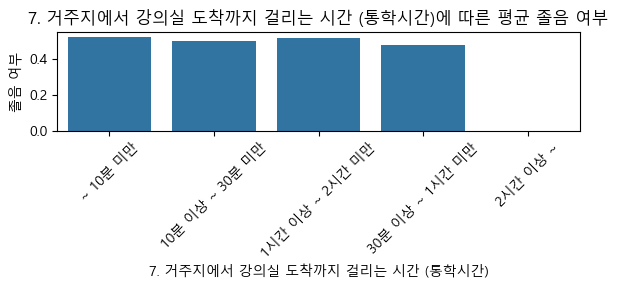

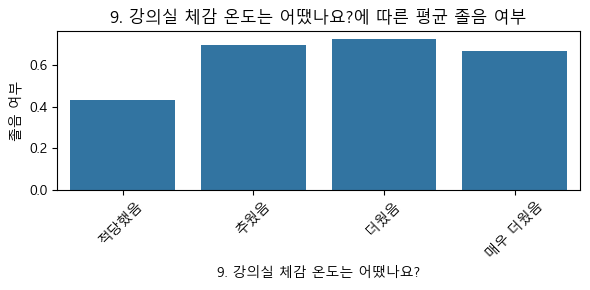

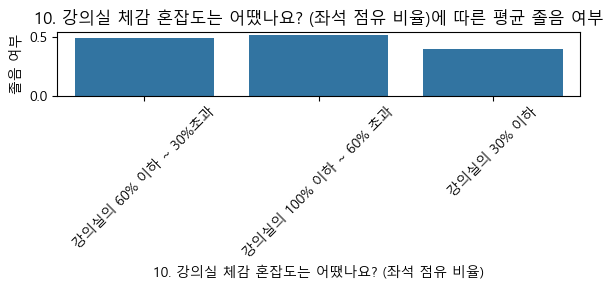

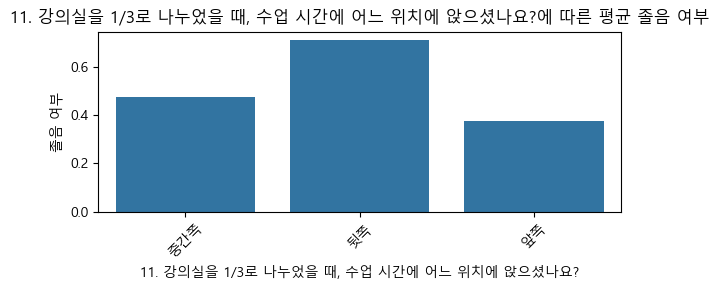

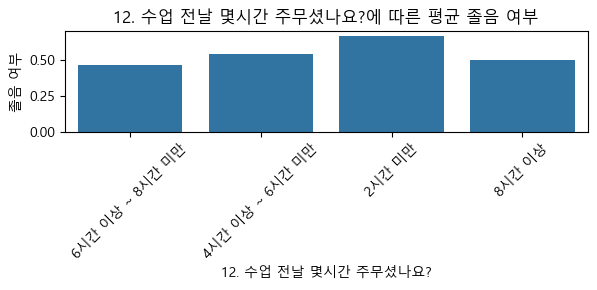

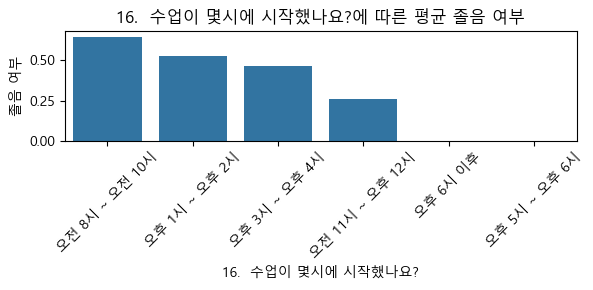

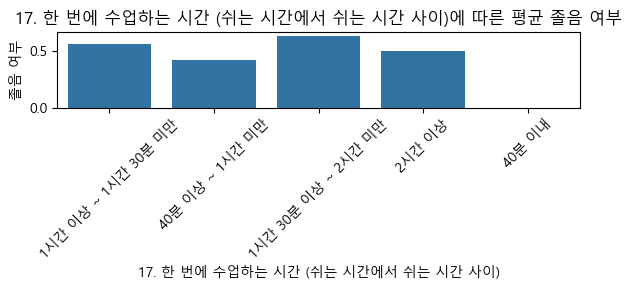

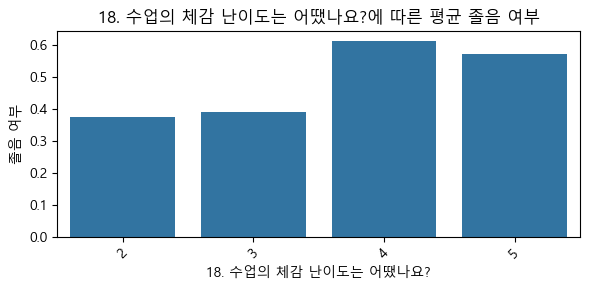

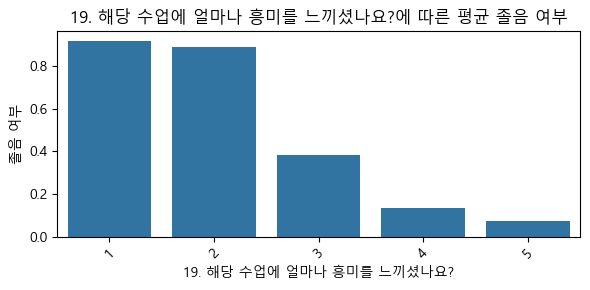

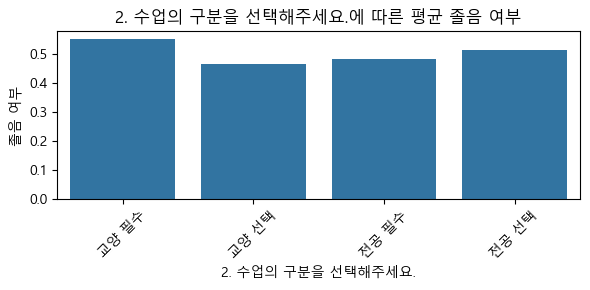

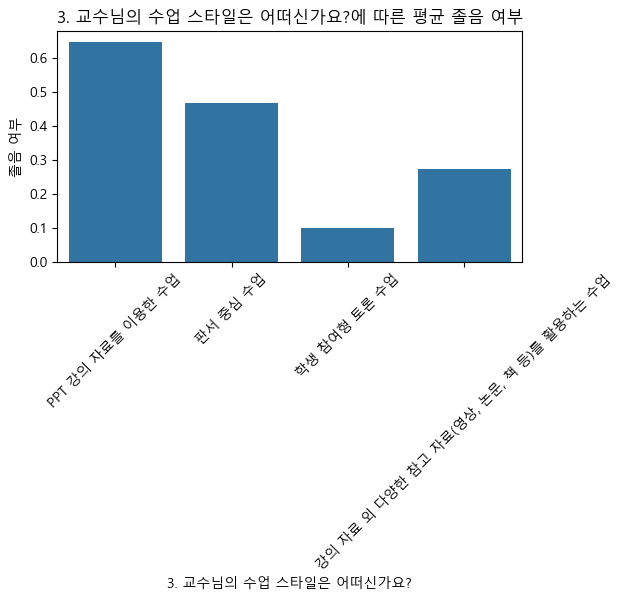

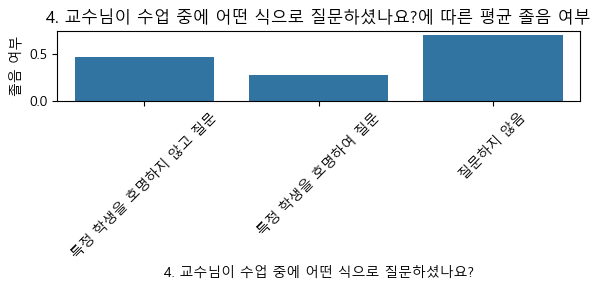

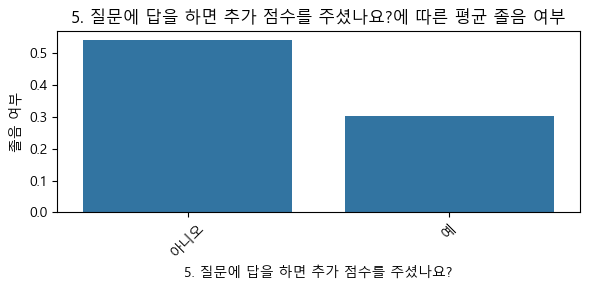

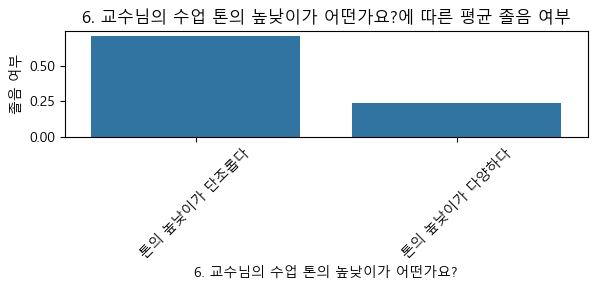

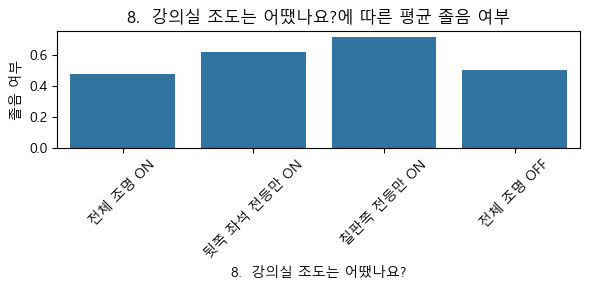

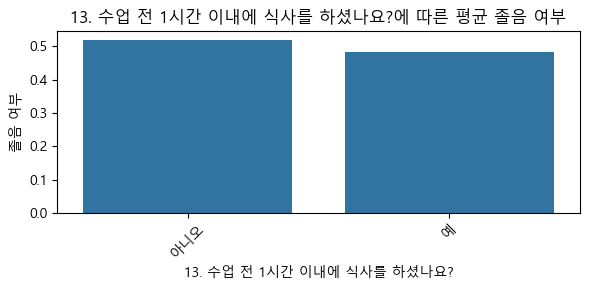

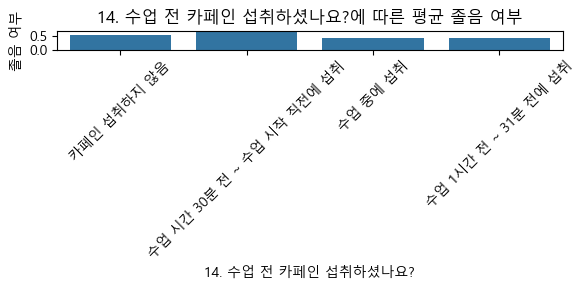

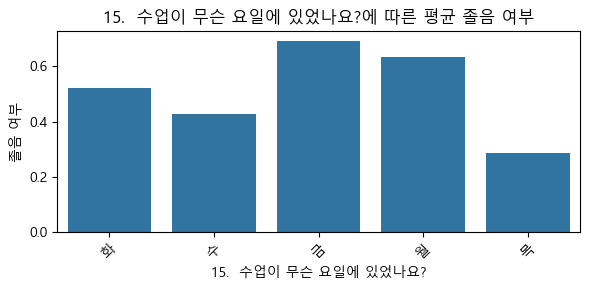

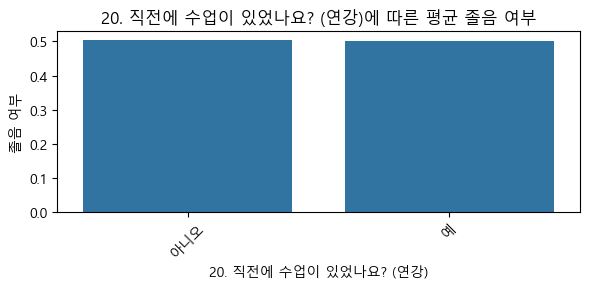

In [73]:
# 응답 항목별 졸음률
for col in ordinal_cols + nominal_cols:
    plt.figure(figsize=(6, 3))
    sns.barplot(x=col, y='졸음 여부', data=df, ci=None)
    plt.xticks(rotation=45)
    plt.title(f"{col}에 따른 평균 졸음 여부")
    plt.tight_layout()
    plt.show()

## 데이터 전처리(인코딩)

In [75]:
ordinal_mappings = {
    '7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간)': {
        '~ 10분 미만': 0,
        '10분 이상 ~ 30분 미만': 1,
        '30분 이상 ~ 1시간 미만': 2,
        '1시간 이상 ~ 2시간 미만': 3,
        '2시간 이상 ~': 4
    },
    '9. 강의실 체감 온도는 어땠나요?': {
        '매우 더웠음': 3,
        '더웠음': 2,
        '적당했음': 1,
        '추웠음': 0
    },
    '10. 강의실 체감 혼잡도는 어땠나요? (좌석 점유 비율)': {
        '강의실의 30% 이하': 0,
        '강의실의 60% 이하 ~ 30%초과': 1,
        '강의실의 100% 이하 ~ 60% 초과': 2
    },
    '11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요?': {
        '앞쪽': 0, '중간쪽': 1, '뒷쪽': 2
    },
    '12. 수업 전날 몇시간 주무셨나요?': {
        '2시간 미만': 0,
        '4시간 이상 ~ 6시간 미만': 1,
        '6시간 이상 ~ 8시간 미만': 2,
        '8시간 이상': 3
    },
    '16.  수업이 몇시에 시작했나요?': {
        '오전 8시 ~ 오전 10시': 0,
        '오전 11시 ~ 오후 12시': 1,
        '오후 1시 ~ 오후 2시': 2,
        '오후 3시 ~ 오후 4시': 3,
        '오후 5시 ~ 오후 6시': 4,
        '오후 6시 이후': 5
    },
    '17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이)': {
        '40분 이내': 0,
        '40분 이상 ~ 1시간 미만': 1,
        '1시간 이상 ~ 1시간 30분 미만': 2,
        '1시간 30분 이상 ~ 2시간 미만': 3,
        '2시간 이상': 4
    }
}

In [76]:
# 순서형 인코딩 (변수에 매핑 적용)
for col, mapping in ordinal_mappings.items():
    df[col] = df[col].map(mapping)
    
# 명목형 인코딩 (One-Hot)
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

In [77]:
# X, 타겟(y) 분리
X = df.drop(columns=[target_col, '현재 학년을 선택해주세요.', '본인 학점을 기입해주세요.', '1. 수업명을 기입해주세요.'], errors='ignore')
y = df[target_col]

In [78]:
df.head()

,현재 학년을 선택해주세요.,본인 학점을 기입해주세요.,1. 수업명을 기입해주세요.,7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간),9. 강의실 체감 온도는 어땠나요?,10. 강의실 체감 혼잡도는 어땠나요? (좌석 점유 비율),"11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요?",12. 수업 전날 몇시간 주무셨나요?,16. 수업이 몇시에 시작했나요?,17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이),...,8. 강의실 조도는 어땠나요?_칠판쪽 전등만 ON,13. 수업 전 1시간 이내에 식사를 하셨나요?_예,14. 수업 전 카페인 섭취하셨나요?_수업 시간 30분 전 ~ 수업 시작 직전에 섭취,14. 수업 전 카페인 섭취하셨나요?_수업 중에 섭취,14. 수업 전 카페인 섭취하셨나요?_카페인 섭취하지 않음,15. 수업이 무슨 요일에 있었나요?_목,15. 수업이 무슨 요일에 있었나요?_수,15. 수업이 무슨 요일에 있었나요?_월,15. 수업이 무슨 요일에 있었나요?_화,20. 직전에 수업이 있었나요? (연강)_예
0,3학년,3.38,동서문명의 교류,0,1,1,1,2,0,2,...,False,False,False,False,True,False,False,False,True,False
1,3학년,3.70,음악의이해,0,0,2,2,2,0,1,...,False,False,False,False,True,False,False,False,True,False
2,4학년,3.50,동역학,1,2,2,1,2,2,1,...,False,True,False,False,True,False,True,False,False,False
3,2학년,3.80,정치의 이해,0,1,2,2,2,3,1,...,False,False,False,False,True,False,False,False,True,True
4,3학년,4.00,현대사회와철학,3,1,2,1,2,0,3,...,False,True,False,False,True,False,False,False,False,False


In [79]:
print("Shape of data:", df.shape)
print("Feature 수:", df.shape[1])

Shape of data: (143, 35)
Feature 수: 35


In [80]:
print("전체 열 개수:", len(df.columns))
print(df.columns)

전체 열 개수: 35
Index(['현재 학년을 선택해주세요.', '본인 학점을 기입해주세요.', '1. 수업명을 기입해주세요.',
       '7. 거주지에서 강의실 도착까지 걸리는 시간 (통학시간)', '9. 강의실 체감 온도는 어땠나요?',
       '10. 강의실 체감 혼잡도는 어땠나요? (좌석 점유 비율)',
       '11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요?', '12. 수업 전날 몇시간 주무셨나요?',
       '16.  수업이 몇시에 시작했나요?', '17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이)',
       '18. 수업의 체감 난이도는 어땠나요?', '19. 해당 수업에 얼마나 흥미를 느끼셨나요?', '졸음 여부',
       '2. 수업의 구분을 선택해주세요._교양 필수', '2. 수업의 구분을 선택해주세요._전공 선택',
       '2. 수업의 구분을 선택해주세요._전공 필수',
       '3. 교수님의 수업 스타일은 어떠신가요?_강의 자료 외 다양한 참고 자료(영상, 논문, 책 등)를 활용하는 수업',
       '3. 교수님의 수업 스타일은 어떠신가요?_판서 중심 수업',
       '3. 교수님의 수업 스타일은 어떠신가요?_학생 참여형 토론 수업',
       '4. 교수님이 수업 중에 어떤 식으로 질문하셨나요?_특정 학생을 호명하여 질문',
       '4. 교수님이 수업 중에 어떤 식으로 질문하셨나요?_특정 학생을 호명하지 않고 질문',
       '5. 질문에 답을 하면 추가 점수를 주셨나요?_예', '6. 교수님의 수업 톤의 높낮이가 어떤가요?_톤의 높낮이가 단조롭다',
       '8.  강의실 조도는 어땠나요?_전체 조명 OFF', '8.  강의실 조도는 어땠나요?_전체 조명 ON',
       '8.  강의실 조도는 어땠나요?_칠판쪽 전등만 ON', '13. 수업 전 1시간 이내에 식사를 하셨나요?_예',
       '14. 수업

## 데이터 분할

In [82]:
# 학습/테스트 데이터 분리
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression
### Feature selection
#### Filter methods

In [84]:
LRbest_score = 0
results = []
k_settings = [5, 10, 15, 20, 30]
C_settings = [0.01, 0.1, 1, 10, 100]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
scaler = StandardScaler()

for k in k_settings:
    for C in C_settings:
        train_f1_scores = []
        val_f1_scores = []
        for train_idx, val_idx in kfold.split(X_trainval, y_trainval):
            # Split
            X_train_fold, y_train_fold = X_trainval.iloc[train_idx], y_trainval.iloc[train_idx]
            X_val_fold, y_val_fold = X_trainval.iloc[val_idx], y_trainval.iloc[val_idx]
            
            # Scaling
            scaler.fit(X_train_fold)
            X_train_fold_scaled = scaler.transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # Feature selection
            selector = SelectKBest(score_func=f_classif, k=k)
            selector.fit(X_train_fold_scaled, y_train_fold)
            X_train_selected = selector.transform(X_train_fold_scaled)
            X_val_selected = selector.transform(X_val_fold_scaled)

            # Train model
            clf = LogisticRegression(C=C)
            clf.fit(X_train_selected, y_train_fold)

            # Predict
            y_train_hat = clf.predict(X_train_selected)
            y_val_hat = clf.predict(X_val_selected)
            
            train_f1_scores.append(f1_score(y_train_fold, y_train_hat))
            val_f1_scores.append(f1_score(y_val_fold, y_val_hat))
        
        results.append({
            'k': k,
            'C': C,
            'train_f1_mean': np.mean(train_f1_scores),
            'val_f1_mean': np.mean(val_f1_scores)
        })
    
        mean_score = np.mean(val_f1_scores)
        
        if mean_score > LRbest_score:
            LRbest_score = mean_score
            LRbest_parameters = {'k': k, 'C': C}

In [85]:
results_df = pd.DataFrame(results)
results_df

,k,C,train_f1_mean,val_f1_mean
0,5,0.01,0.854229,0.833924
1,5,0.10,0.858271,0.844530
2,5,1.00,0.861811,0.831197
3,5,10.00,0.867035,0.840171
4,5,100.00,0.869003,0.840171
5,10,0.01,0.898913,0.858469
6,10,0.10,0.902862,0.847358
7,10,1.00,0.904369,0.831298
8,10,10.00,0.911102,0.826298
9,10,100.00,0.911102,0.826298


In [86]:
print("Best score on validation set: {:.2f}".format(LRbest_score))
print("Best hyperparameters: {}".format(LRbest_parameters))

Best score on validation set: 0.87
Best hyperparameters: {'k': 15, 'C': 0.01}


## RandomForest

In [88]:
RFbest_score = 0
results_rf = []
n_settings = [1, 2, 5, 10 ,20, 50, 100]
max_features_settings = ['sqrt', 'log2', None]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for n in n_settings:
    for maxf in max_features_settings:
        train_f1_scores = []
        val_f1_scores = []
        for train_idx, val_idx in kfold.split(X_trainval, y_trainval):
            # Split
            X_train_fold, y_train_fold = X_trainval.iloc[train_idx], y_trainval.iloc[train_idx]
            X_val_fold, y_val_fold = X_trainval.iloc[val_idx], y_trainval.iloc[val_idx]
                
            # Train model
            forest = RandomForestClassifier(n_estimators=n, max_features=maxf, random_state=42)
            forest.fit(X_train_fold, y_train_fold)

            # Predict
            y_train_hat = forest.predict(X_train_fold)
            y_val_hat = forest.predict(X_val_fold)
                
            train_f1_scores.append(f1_score(y_train_fold, y_train_hat))
            val_f1_scores.append(f1_score(y_val_fold, y_val_hat))
        
        results_rf.append({
            'n_estimators': n,
            'max_features': maxf,
            'train_f1_mean': np.mean(train_f1_scores),
            'val_f1_mean': np.mean(val_f1_scores)
        })
        
        mean_score = np.mean(val_f1_scores)
        
        if mean_score > RFbest_score:
            RFbest_score = mean_score
            RFbest_parameters = {'n_estimators': n, 'max_features': maxf}

In [89]:
results_rf_df = pd.DataFrame(results_rf)
results_rf_df

,n_estimators,max_features,train_f1_mean,val_f1_mean
0,1,sqrt,0.876286,0.630862
1,1,log2,0.872966,0.683257
2,1,None,0.896733,0.773348
3,2,sqrt,0.854163,0.536717
4,2,log2,0.863887,0.588485
5,2,None,0.893860,0.770101
6,5,sqrt,0.964047,0.810544
7,5,log2,0.963004,0.691353
8,5,None,0.961947,0.767273
9,10,sqrt,0.977893,0.786681


In [90]:
print("Best score on validation set: {:.2f}".format(RFbest_score))
print("Best hyperparameters: {}".format(RFbest_parameters))

Best score on validation set: 0.81
Best hyperparameters: {'n_estimators': 100, 'max_features': 'sqrt'}


## 모델별 최고 성능 비교표

In [92]:
# 모델별 최적 하이퍼파라미터 및 Best cross-validation score 비교표
compare_df = pd.DataFrame([
    {
        "Model": "LogisticRegression",
        "CV F1 (mean)": LRbest_score,
        "Best Params": LRbest_parameters
    },
    {
        "Model": "RandomForest",
        "CV F1 (mean)": RFbest_score,
        "Best Params": RFbest_parameters
    }
])
compare_df

,Model,CV F1 (mean),Best Params
0,LogisticRegression,0.873520,"{'k': 15, 'C': 0.01}"
1,RandomForest,0.814802,"{'n_estimators': 100, 'max_features': 'sqrt'}"


## 최종 성능(Test)

In [94]:
# 비교표에서 우위에 있던 모델을 가지고 test셋으로 최종 모델 성능 도출하기
scaler = StandardScaler()
X_trainval_scaled = scaler.fit_transform(X_trainval)
X_test_scaled = scaler.transform(X_test)

select = SelectKBest(f_classif, k=15)
select.fit(X_trainval_scaled, y_trainval)
X_trainval_selected = select.transform(X_trainval_scaled)
X_test_selected = select.transform(X_test_scaled)

final = LogisticRegression(C=0.01)
final.fit(X_trainval_selected, y_trainval)

y_test_hat = final.predict(X_test_selected)

test_acc = accuracy_score(y_test, y_test_hat)
test_f1 = f1_score(y_test, y_test_hat)
print("Test set acc with best hyperparameters: {:.2f}".format(test_acc))
print("Test set f1 with best hyperparameters: {:.2f}".format(test_f1))

Test set acc with best hyperparameters: 0.83
Test set f1 with best hyperparameters: 0.86


## 해석

### Feature Coefficient

In [97]:
# 올바른 변수 이름 추출
selected_features = X_trainval.columns[select.get_support()]

In [98]:
# model은 LogisticRegression -> final (이미 fit된 상태)
coef_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# 양수 계수 -> 졸음 유발 높임
positive_coef = coef_df[coef_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(10)

# 음수 계수 -> 졸음 억제
negative_coef = coef_df[coef_df['Coefficient'] < 0].sort_values(by='Coefficient').head(10)

print("▶ 졸음 유발 가능성 높은 특성 (계수 +):")
print(positive_coef)

print("\n▶ 졸음 유발 가능성 낮은 특성 (계수 -):")
print(negative_coef)

▶ 졸음 유발 가능성 높은 특성 (계수 +):
                                            Feature  Coefficient
9             6. 교수님의 수업 톤의 높낮이가 어떤가요?_톤의 높낮이가 단조롭다     0.166634
0        11. 강의실을 1/3로 나누었을 때, 수업 시간에 어느 위치에 앉으셨나요?     0.127652
14                          15.  수업이 무슨 요일에 있었나요?_월     0.063001
3                             18. 수업의 체감 난이도는 어땠나요?     0.060490
2               17. 한 번에 수업하는 시간 (쉬는 시간에서 쉬는 시간 사이)     0.036800
10  14. 수업 전 카페인 섭취하셨나요?_수업 시간 30분 전 ~ 수업 시작 직전에 섭취     0.028245

▶ 졸음 유발 가능성 낮은 특성 (계수 -):
                                              Feature  Coefficient
4                           19. 해당 수업에 얼마나 흥미를 느끼셨나요?    -0.263991
6                 3. 교수님의 수업 스타일은 어떠신가요?_학생 참여형 토론 수업    -0.127990
7         4. 교수님이 수업 중에 어떤 식으로 질문하셨나요?_특정 학생을 호명하여 질문    -0.113043
8                         5. 질문에 답을 하면 추가 점수를 주셨나요?_예    -0.055600
5   3. 교수님의 수업 스타일은 어떠신가요?_강의 자료 외 다양한 참고 자료(영상, 논...    -0.055158
12                            15.  수업이 무슨 요일에 있었나요?_목    -0.054724
11                     

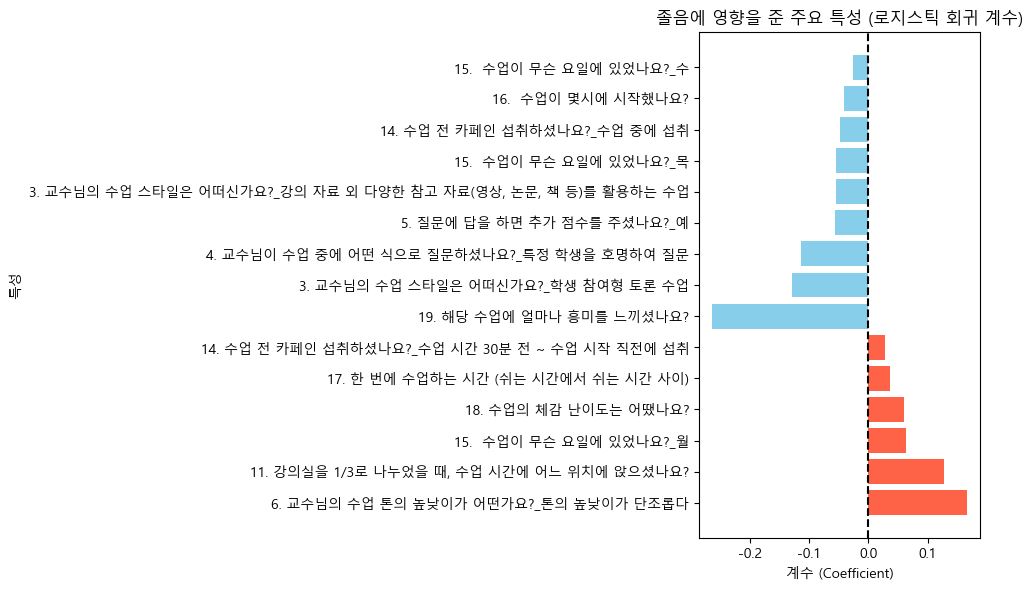

In [99]:
top_features = pd.concat([positive_coef, negative_coef])

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'],
         color=np.where(top_features['Coefficient'] > 0, 'tomato', 'skyblue'))
plt.axvline(0, color='black', linestyle='--')
plt.title('졸음에 영향을 준 주요 특성 (로지스틱 회귀 계수)')
plt.xlabel('계수 (Coefficient)')
plt.ylabel('특성')
plt.tight_layout()
plt.show()